In [1]:
from __future__ import print_function, division

import thinkdsp
import thinkplot

import numpy as np

import warnings
warnings.filterwarnings('ignore')

PI2 = 2 * np.pi

np.set_printoptions(precision=3, suppress=True)
%matplotlib inline

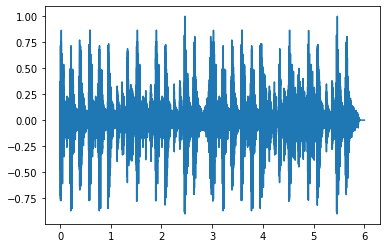

In [3]:
wave = thinkdsp.read_wave('263868__kevcio__amen-break-a-160-bpm.wav')
wave.normalize()
wave.plot()

該信號以44100 Hz採樣。聽起來就是這樣。

In [4]:
wave.make_audio()

這是頻譜：

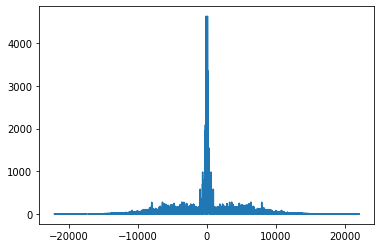

In [5]:
wave.make_spectrum(full=True).plot()

即使已經對該信號進行了採樣，我們還是假裝沒有採樣。因此，我們將原始波視為連續的模擬信號。
現在，我將通過保持每個第4個採樣並將其餘的採樣率設置為零，以幀速率的1/4（11025 Hz）對其進行採樣。

In [6]:
def sample(wave, factor):
    """Simulates sampling of a wave.
    
    wave: Wave object
    factor: ratio of the new framerate to the original
    """
    ys = np.zeros(len(wave))
    ys[::factor] = wave.ys[::factor]
    return thinkdsp.Wave(ys, framerate=wave.framerate)

結果聽起來不是很好。它具有許多額外的高頻成分。

In [7]:
sampled = sample(wave, 4)
sampled.make_audio()

如果我們看一下頻譜，我們會看到額外的成分。

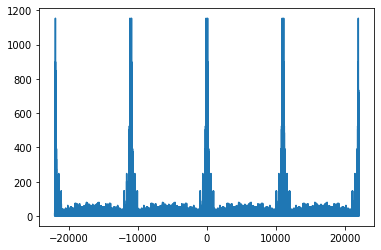

In [8]:
sampled.make_spectrum(full=True).plot()

要了解這些信號來自何處，可以將採樣視為與“脈衝序列”相乘。以下函數與樣本相似，但是使脈衝序列變得清晰。

In [9]:
def make_impulses(wave, factor):
    ys = np.zeros(len(wave))
    ys[::factor] = 1
    ts = np.arange(len(wave)) / wave.framerate
    return thinkdsp.Wave(ys, ts, wave.framerate)

impulses = make_impulses(wave, 4)

乘以脈衝與採樣具有相同的效果。

In [10]:
sampled = wave * impulses
sampled.make_audio()

現在，如果我們看一下脈衝頻譜，我們可以看到頻域中正在發生的事情。

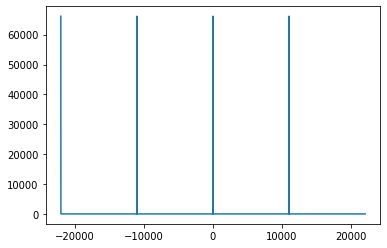

In [11]:
impulses.make_spectrum(full=True).plot()

乘以脈衝可得到原始頻譜的4個移位副本。其中之一從頻譜的負端繞到正，這就是為什麼在採樣波的頻譜中有5個峰的原因。

In [12]:
def show_impulses(wave, factor):
    impulses = make_impulses(wave, factor)
    thinkplot.preplot(2, cols=2)
    impulses.segment(0, 0.001).plot_vlines(linewidth=2)
    thinkplot.config(xlabel='Time (s)')
    
    thinkplot.subplot(2)
    impulses.make_spectrum(full=True).plot()
    thinkplot.config(xlabel='Frequency (Hz)', xlim=[-22400, 22400])

隨著採樣次數的減少，它們在時域中的距離越來越遠，而頻譜的副本在頻域中的距離也越來越近。
在下面更改採樣因子時，您可以看到效果。

In [14]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

slider = widgets.IntSlider(min=2, max=32, value=4)
interact(show_impulses, wave=fixed(wave), factor=slider);

interactive(children=(IntSlider(value=4, description='factor', max=32, min=2), Output()), _dom_classes=('widge…

要恢復原始波形，我們可以應用低通濾波器來掩蓋不需要的副本。該波的採樣頻率為11025 Hz，因此我們將其以5512.5的Nyquist特頻率截止。

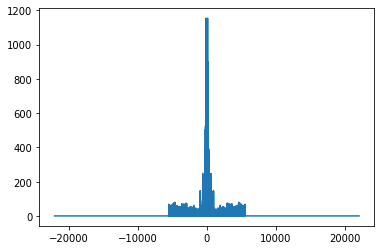

In [15]:
spectrum = sampled.make_spectrum(full=True)
spectrum.low_pass(5512.5)
spectrum.plot()

結果聽起來與原始版本有很大不同，原因有兩個：

1.因為我們必須切斷大約5512.5 Hz的頻率，所以我們損失了原始信號的某些高頻分量。
2.即使對於低於5512.5 Hz的頻率，頻譜也不是完全正確，因為它包括多餘副本剩餘的貢獻。

In [16]:
filtered = spectrum.make_wave()
filtered.make_audio()

我們可以看到原始信號與採樣/濾波信號不同：

In [17]:
def plot_segments(original, filtered):
    start = 1
    duration = 0.01
    original.segment(start=start, duration=duration).plot(color='gray')
    filtered.segment(start=start, duration=duration).plot()

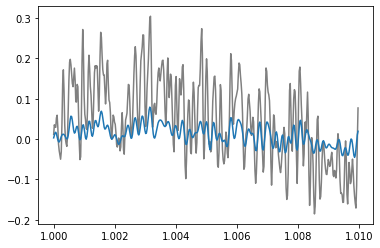

In [19]:
plot_segments(wave, filtered)

由於該信號包含高於Nyquist特頻率的許多分量，因此採樣效果不佳。